In [1]:
import sys
import _pickle as pickle
import numpy as np
from datetime import datetime

In [2]:
def convert_to_icd9(dxStr):
    # "E1234" -> "E123.4"
    if dxStr.startswith('E'):
        if len(dxStr) > 4:
            return dxStr[:4] + '.' + dxStr[4:]
        else:
            return dxStr
    else:
        # "1234" -> "123.4"
        if len(dxStr) > 3: 
            return dxStr[:3] + '.' + dxStr[3:]
        else:
            return dxStr

In [3]:
def convert_to_3digit_icd9(dxStr):
    if dxStr.startswith('E'):
        if len(dxStr) > 4:
            return dxStr[:4]
        else:
            return dxStr
    else:
        if len(dxStr) > 3: 
            return dxStr[:3]
        else:
            return dxStr

In [4]:
raw_data_dir = 'mimic/'
processed_data_dir = 'processed_mimic/'
admissionFile = raw_data_dir + 'ADMISSIONS.csv'
diagnosisFile = raw_data_dir + 'DIAGNOSES_ICD.csv'
outFile = processed_data_dir + 'processed_mimic'

In [ ]:
# input arguments
binary_count = 'binary'

In [6]:
print('Building pid-admission mapping, admission-date mapping')
pidAdmMap = {}
admDateMap = {}
infd = open(admissionFile, 'r')
infd.readline()
for line in infd:
    tokens = line.strip().split(',')
    pid = int(tokens[1])
    admId = int(tokens[2])
    admTime = datetime.strptime(tokens[3], '%Y-%m-%d %H:%M:%S')
    admDateMap[admId] = admTime
    if pid in pidAdmMap: pidAdmMap[pid].append(admId)
    else: pidAdmMap[pid] = [admId]
infd.close()

print('Building admission-dxList mapping')
admDxMap = {}
infd = open(diagnosisFile, 'r')
infd.readline()
for line in infd:
    tokens = line.strip().split(',')
    admId = int(tokens[2])
    # Uncomment this line and comment the line below, if you want to use the entire ICD9 digits.
    dxStr = 'D_' + convert_to_icd9(tokens[4][1:-1])
    #dxStr = 'D_' + convert_to_3digit_icd9(tokens[4][1:-1])
    if admId in admDxMap: admDxMap[admId].append(dxStr)
    else: admDxMap[admId] = [dxStr]
infd.close()

print('Building pid-sortedVisits mapping')
pidSeqMap = {}
for pid, admIdList in pidAdmMap.items():
    #if len(admIdList) < 2: continue
    sortedList = sorted([(admDateMap[admId], admDxMap[admId]) for admId in admIdList])
    pidSeqMap[pid] = sortedList

print('Building pids, dates, strSeqs')
pids = []
dates = []
seqs = []
for pid, visits in pidSeqMap.items():
    pids.append(pid)
    seq = []
    date = []
    for visit in visits:
        date.append(visit[0])
        seq.append(visit[1])
    dates.append(date)
    seqs.append(seq)

print('Converting strSeqs to intSeqs, and making types')
types = {}
newSeqs = []
for patient in seqs:
    newPatient = []
    for visit in patient:
        newVisit = []
        for code in visit:
            if code in types:
                newVisit.append(types[code])
            else:
                types[code] = len(types)
                newVisit.append(types[code])
        newPatient.append(newVisit)
    newSeqs.append(newPatient)

print('Constructing the matrix')
numPatients = len(newSeqs)
numCodes = len(types)
matrix = np.zeros((numPatients, numCodes)).astype('float32')
for i, patient in enumerate(newSeqs):
    for visit in patient:
        for code in visit:
            if binary_count == 'binary':
                matrix[i][code] = 1.
            else:
                matrix[i][code] += 1.

pickle.dump(pids, open(outFile+'.pids', 'wb'), -1)
pickle.dump(matrix, open(outFile+'.matrix', 'wb'), -1)
pickle.dump(types, open(outFile+'.types', 'wb'), -1)

Building pid-admission mapping, admission-date mapping
Building admission-dxList mapping
Building pid-sortedVisits mapping
Building pids, dates, strSeqs
Converting strSeqs to intSeqs, and making types
Constructing the matrix


In [9]:
with open('processed_mimic/processed_mimic.types', 'rb') as f:
    types = pickle.load(f)

with open('processed_mimic/processed_mimic.pids', 'rb') as f:
    pids = pickle.load(f)

with open('processed_mimic/processed_mimic.matrix', 'rb') as f:
    matrix = pickle.load(f)

In [13]:
for i, (code, idx) in enumerate(list(types.items())[280:]):
    print(f"   {code} -> {idx}")

   D_240 -> 280
   D_284 -> 281
   D_159 -> 282
   D_890 -> 283
   D_265 -> 284
   D_118 -> 285
   D_625 -> 286
   D_349 -> 287
   D_937 -> 288
   D_319 -> 289
   D_13 -> 290
   D_169 -> 291
   D_873 -> 292
   D_942 -> 293
   D_518 -> 294


### 如何读取parquet文件？

In [ ]:
import pandas as pd

# 读取 parquet 文件
df = pd.read_parquet("patient_sequence.parquet")

# 看前几行
print(df.head())

# 查看列信息
print(df.columns)

# 数据基本情况
print(df.info())
print(df.describe(include="all"))

### 把.matrix文件转为.npy格式

In [7]:
# 将 processed_mimic.matrix 转换为 .npy 格式
import pickle
import numpy as np

print("正在读取 processed_mimic.matrix...")
with open('processed_mimic/processed_mimic.matrix', 'rb') as f:
    matrix = pickle.load(f)

print(f"矩阵形状: {matrix.shape}")
print(f"数据类型: {matrix.dtype}")
print(f"非零元素数量: {np.count_nonzero(matrix)}")

# 保存为 .npy 格式
print("正在保存为 .npy 格式...")
np.save('processed_mimic/train_mimic3.npy', matrix)

print("转换完成！")
print("现在您可以使用以下代码加载矩阵:")
print("import numpy as np")
print("matrix = np.load('processed_mimic/train_mimic3.npy')")


正在读取 processed_mimic.matrix...
矩阵形状: (46520, 6985)
数据类型: float32
非零元素数量: 586919
正在保存为 .npy 格式...
转换完成！
现在您可以使用以下代码加载矩阵:
import numpy as np
matrix = np.load('processed_mimic/train_mimic3.npy')


In [9]:
# 验证转换结果
print("验证转换结果...")

# 重新加载原始矩阵
with open('processed_mimic/processed_mimic.matrix', 'rb') as f:
    original_matrix = pickle.load(f)

# 加载新保存的 .npy 文件
npy_matrix = np.load('processed_mimic/train_mimic3.npy')

print(f"原始矩阵形状: {original_matrix.shape}")
print(f".npy 矩阵形状: {npy_matrix.shape}")
print(f"两个矩阵是否相同: {np.array_equal(original_matrix, npy_matrix)}")

# 显示文件大小对比
import os
original_size = os.path.getsize('processed_mimic/processed_mimic.matrix')
npy_size = os.path.getsize('processed_mimic/train_mimic3.npy')

print(f"\n文件大小对比:")
print(f"原始文件 (.matrix): {original_size:,} 字节")
print(f"新文件 (.npy): {npy_size:,} 字节")
print(f"大小变化: {((npy_size - original_size) / original_size * 100):+.1f}%")

print("\n✓ 转换成功！现在您有了 .npy 格式的矩阵文件")


验证转换结果...
原始矩阵形状: (46520, 6985)
.npy 矩阵形状: (46520, 6985)
两个矩阵是否相同: True

文件大小对比:
原始文件 (.matrix): 1,299,768,939 字节
新文件 (.npy): 1,299,768,928 字节
大小变化: -0.0%

✓ 转换成功！现在您有了 .npy 格式的矩阵文件


### 可视化training log
##### 把loss信息加入到train_log.txt文件中

/var/folders/fn/_32pmlmn6zq_hpq142dgnrv00000gq/T/ipykernel_50710/3804025786.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


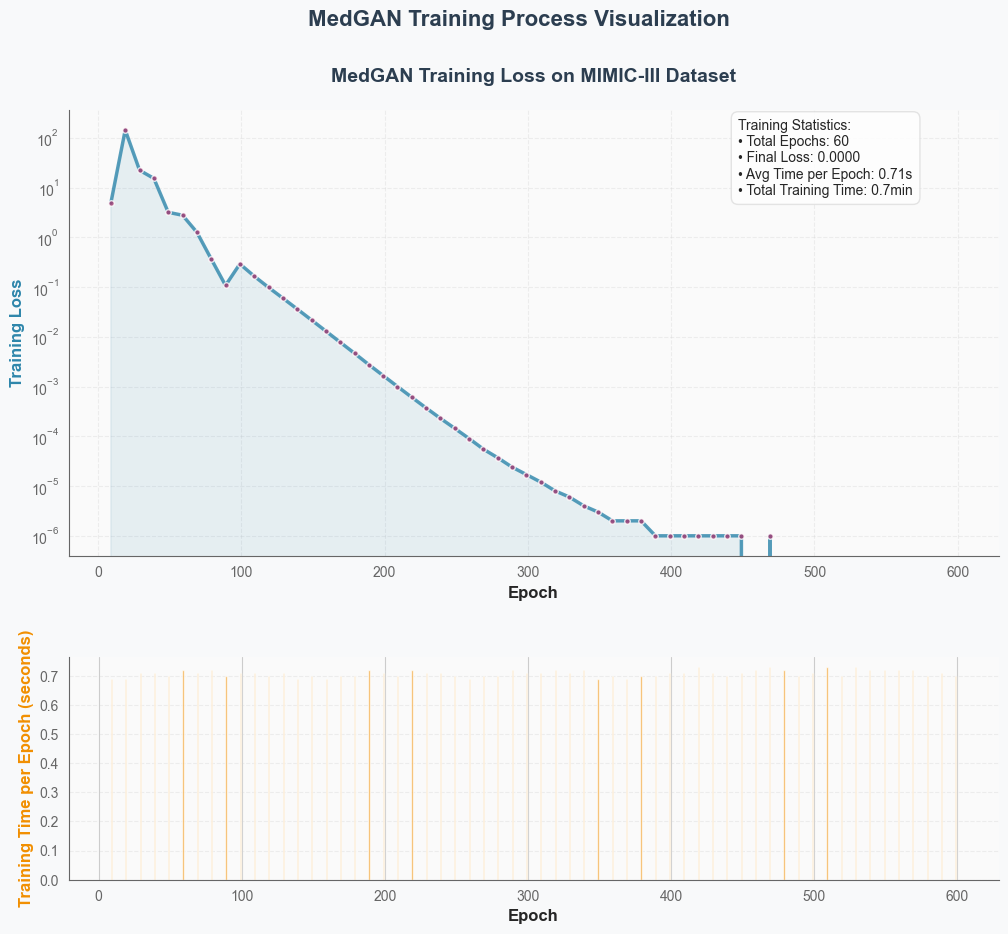

🎯 MedGAN Training Summary
📊 Total Epochs: 60
📉 Initial Loss: 4.9339
📉 Final Loss: 0.0000
📈 Loss Improvement: 100.0%
⏱️  Average Time per Epoch: 0.71s
⏱️  Total Training Time: 0.7min
🚀 Fastest Epoch: 0.69s (Epoch 9)
🐌 Slowest Epoch: 0.73s (Epoch 419)


In [11]:
import re
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns

# 设置英文字体和样式
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# 读取日志
with open("train_mimic3_log.txt") as f:
    lines = f.readlines()

epochs, losses, times = [], [], []

for line in lines:
    match = re.match(r"epoch:\s*(\d+),\s*loss\s*=\s*([\d\.]+)\s*\(([\d\.]+)\)", line.strip())
    if match:
        epochs.append(int(match.group(1)))
        losses.append(float(match.group(2)))
        times.append(float(match.group(3)))

# 创建更美观的图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                               gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.3})

# 设置整体背景色
fig.patch.set_facecolor('#f8f9fa')

# 第一个子图：Loss曲线
ax1.plot(epochs, losses, linewidth=2.5, color='#2E86AB', alpha=0.8, 
         marker='o', markersize=4, markerfacecolor='#A23B72', markeredgecolor='white', markeredgewidth=1)
ax1.set_ylabel('Training Loss', fontsize=12, fontweight='bold', color='#2E86AB')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#fafafa')

# 添加渐变填充
ax1.fill_between(epochs, losses, alpha=0.1, color='#2E86AB')

# 美化第一个子图
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#666666')
ax1.spines['bottom'].set_color('#666666')
ax1.tick_params(colors='#666666', labelsize=10)

# 添加标题
ax1.set_title('MedGAN Training Loss on MIMIC-III Dataset', 
              fontsize=14, fontweight='bold', pad=20, color='#2c3e50')

# 第二个子图：训练时间
bars = ax2.bar(epochs, times, width=0.8, color='#F18F01', alpha=0.7, 
               edgecolor='white', linewidth=1)
ax2.set_ylabel('Training Time per Epoch (seconds)', fontsize=12, fontweight='bold', color='#F18F01')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
ax2.set_facecolor('#fafafa')

# 美化第二个子图
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('#666666')
ax2.spines['bottom'].set_color('#666666')
ax2.tick_params(colors='#666666', labelsize=10)

# 添加统计信息文本框
stats_text = f"""Training Statistics:
• Total Epochs: {len(epochs)}
• Final Loss: {losses[-1]:.4f}
• Avg Time per Epoch: {np.mean(times):.2f}s
• Total Training Time: {np.sum(times)/60:.1f}min"""

# 在图上添加统计信息
ax1.text(0.72, 0.98, stats_text, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='#ddd'))

# 调整布局
plt.tight_layout()

# 添加整体标题
fig.suptitle('MedGAN Training Process Visualization', fontsize=16, fontweight='bold', y=0.98, color='#2c3e50')

plt.show()

# 打印训练总结
print("="*60)
print("🎯 MedGAN Training Summary")
print("="*60)
print(f"📊 Total Epochs: {len(epochs)}")
print(f"📉 Initial Loss: {losses[0]:.4f}")
print(f"📉 Final Loss: {losses[-1]:.4f}")
print(f"📈 Loss Improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")
print(f"⏱️  Average Time per Epoch: {np.mean(times):.2f}s")
print(f"⏱️  Total Training Time: {np.sum(times)/60:.1f}min")
print(f"🚀 Fastest Epoch: {min(times):.2f}s (Epoch {epochs[times.index(min(times))]})")
print(f"🐌 Slowest Epoch: {max(times):.2f}s (Epoch {epochs[times.index(max(times))]})")
print("="*60)
